In [2]:
import pandas as pd
import numpy as np

def loader():
    """Reading data from keys"""
    with open("data/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("data/data_{}.csv".format(str(key)))

    return dictex

In [19]:
df = loader()

In [3]:
# from horizon_handler
HORIZON_FEATURES = ['radiation', 'shade']

# from SMHI
FCST_FEATURES = ['AirTemp', 'DewPoint', 'RainPrecip', 'SnowPrecip', 'SnowPrecipAccumulated', 'WindSpeed',
                 'AirPressure', 'OctalCloudCoverage', 'PrecipAmount']
# from METRo
EBM_FEATURES = ['air_temp', 'dew_point', 'surf_temp', 'water_amount', 'snow_amount', 'sub_temp']


# setting the independent and dependent features
INDEPENDENT_FEATURES = HORIZON_FEATURES + FCST_FEATURES + EBM_FEATURES

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
import sys
import pickle

def create_model(neurons=1):
    # create model
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=17))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model
    
def get_best_parameters(samples, targets):
    model = KerasRegressor(build_fn=create_model, epochs=20, batch_size=50, verbose=0) 

    # Define the range
    neurons = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
    batch_size = [10, 20, 40, 50, 60, 80, 100]
    epochs = [10, 20, 40, 50, 100]
    param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs)
    
    dnn_random = RandomizedSearchCV(estimator = model, param_distributions = param_grid, cv = 3, verbose=0, n_iter = 100)
    dnn_random.fit(samples, targets)
    
    return dnn_random.best_params_
    

def fit_nn(samples, targets, neurons=238, epochs=20, batch_size=50):
    model = Sequential()
    model.add(Dense(neurons, activation='relu',
             input_shape=(samples.shape[1],)))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    model.fit(samples, targets,
             epochs=epochs, batch_size=batch_size, verbose=0)
    
    #p = pickle.dumps(model)
    #print(sys.getsizeof(p))
    return model

def forecast_nn(model, samples):
    predictions = model.predict(samples)
    return predictions

def normalize(train, test):
    mean = train.mean(axis=0)    
    train -= mean
    std = train.std(axis=0)
    train /= std

    test -= mean
    test /= std
    return train, test

def getValues(data):
    data.set_index("Date Time", inplace=True)
    included = np.array(data[INDEPENDENT_FEATURES + ['surf_temp_sqerror']].notnull().all(axis=1))
    rsi = {
        "data": data.loc[included, INDEPENDENT_FEATURES].values.astype(np.float), 
        "target": data.loc[included, 'surf_temp_sqerror'].values.astype(np.float)
    }
    return train_test_split(rsi["data"], rsi["target"], test_size=0.3, random_state=0)


Using TensorFlow backend.


In [343]:
dfTest = loader()
neuron_params = dict()

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in dfTest.keys():
    if allowed_key(key):
        X_train, X_test, y_train, y_test = getValues(dfTest[key])
        
        best_params = get_best_parameters(X_train, y_train)
        neuron_params[key] = best_params
        print(key, best_params)

KeyboardInterrupt: 

In [22]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

def plotPredictions(key, true, predictions):
    plt.figure(figsize=(16,7))
    plt.subplot(121)
    pyplot.scatter(true, predictions, color="red", alpha=0.5, s=10)
    pyplot.xlim(0,20)
    pyplot.ylim(0,20)
    pyplot.plot(range(60), color='black', alpha=0.2)
    pyplot.grid()
    pyplot.title(key, fontsize=16)
    pyplot.xlabel('surf_temp_sqerror')
    pyplot.ylabel('Estimated surf_temp_sqerror')

In [23]:
def experiment(repeats, data, key, params):
    X_train, X_test, y_train, y_test = getValues(data)
    X_train, X_test = normalize(X_train, X_test)
    
    MSE_benchmark = 100
    index_val = 20
    predictionsBest = list()
    trueBest = list()

    error_scores = list()
    results = pd.DataFrame()
    print(key)
    for r in range(repeats):
        forest_model = fit_nn(X_train, 
                              y_train, 
                              neurons=params['neurons'],
                              epochs=params['epochs'],
                              batch_size=params['batch_size'])
        
        forest_model.save('models/dnn/whole_models/model_{}_{}.h5'.format(key, r))
        
        predictions = forecast_nn(forest_model, X_test)
        true = y_test
    
        # report performance
        mse = mean_squared_error(true, predictions)
        print('%d) Test MSE: %.3f' % (r+1, mse))
        error_scores.append(mse)
        # plotPredictions(key, true, predictions)
        if (mse < MSE_benchmark):
            MSE_benchmark = mse
            predictionsBest = predictions
            trueBest = true
            index_val = r
    print(index_val, )
    return trueBest, predictionsBest, error_scores

In [5]:
neuron_params = dict()

neuron_params[(1419, 1)] = {'neurons': 74, 'epochs': 100, 'batch_size': 10}
neuron_params[(1419, 5)] = {'neurons': 235, 'epochs': 100, 'batch_size': 20}
neuron_params[(1419, 9)] = {'neurons': 267, 'epochs': 40, 'batch_size': 20}
neuron_params[(1419, 18)] = {'neurons': 138, 'epochs': 40, 'batch_size': 10}
neuron_params[(1433, 1)] = {'neurons': 138, 'epochs': 100, 'batch_size': 10}
neuron_params[(1433, 5)] = {'neurons': 267, 'epochs': 50, 'batch_size': 40}
neuron_params[(1433, 9)] = {'neurons': 267, 'epochs': 40, 'batch_size': 40}
neuron_params[(1433, 18)] = {'neurons': 235, 'epochs': 50, 'batch_size': 40}
neuron_params[(1440, 1)] = {'neurons': 300, 'epochs': 40, 'batch_size': 20}
neuron_params[(1440, 5)] = {'neurons': 203, 'epochs': 40, 'batch_size': 20}
neuron_params[(1440, 9)] = {'neurons': 267, 'epochs': 50, 'batch_size': 20}
neuron_params[(1440, 18)] = {'neurons': 300, 'epochs': 50, 'batch_size': 20}
neuron_params[(1417, 1)] = {'neurons': 267, 'epochs': 40, 'batch_size': 50}
neuron_params[(1417, 5)] = {'neurons': 235, 'epochs': 50, 'batch_size': 20}
neuron_params[(1417, 9)] = {'neurons': 300, 'epochs': 40, 'batch_size': 20}
neuron_params[(1417, 18)] = {'neurons': 171, 'epochs': 50, 'batch_size': 20}
# 

In [25]:
%matplotlib inline

df = loader()

del df[(1419, 1)]
del df[(1419, 5)]
del df[(1419, 9)]
del df[(1419, 18)]
del df[(1433, 1)]
del df[(1433, 5)]
del df[(1433, 9)]
del df[(1433, 18)]
del df[(1440, 1)]
del df[(1440, 5)]
del df[(1440, 9)]
del df[(1440, 18)]

repeats = 10
features = 1
results = dict()

trueVals = []
predictedVals = []

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        true, predictions, error_scores = experiment(repeats, df[key], key, neuron_params[key])
        results[key] = error_scores
        trueVals.extend(true)
        predictedVals.extend(predictions)
    

(1417, 1)
1) Test MSE: 0.853
2) Test MSE: 0.843
3) Test MSE: 0.873
4) Test MSE: 0.862
5) Test MSE: 0.851
6) Test MSE: 0.893
7) Test MSE: 0.832
8) Test MSE: 0.857
9) Test MSE: 0.853
10) Test MSE: 0.870
6
(1417, 5)
1) Test MSE: 4.412
2) Test MSE: 4.154
3) Test MSE: 4.935
4) Test MSE: 5.177
5) Test MSE: 5.279
6) Test MSE: 4.334
7) Test MSE: 4.671
8) Test MSE: 4.013
9) Test MSE: 4.130
10) Test MSE: 4.406
7
(1417, 9)
1) Test MSE: 9.713
2) Test MSE: 8.926
3) Test MSE: 9.028
4) Test MSE: 9.020
5) Test MSE: 9.013
6) Test MSE: 9.131
7) Test MSE: 8.300
8) Test MSE: 8.262
9) Test MSE: 8.991
10) Test MSE: 9.035
7
(1417, 18)
1) Test MSE: 9.482
2) Test MSE: 9.170
3) Test MSE: 10.913
4) Test MSE: 9.236
5) Test MSE: 10.290
6) Test MSE: 8.596
7) Test MSE: 9.097
8) Test MSE: 10.657
9) Test MSE: 8.799
10) Test MSE: 9.049
5


In [6]:
import pandas as pd
import numpy as np

def loader2():
    """Reading data from keys"""
    with open("data2/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("data2/data_{}.csv".format(str(key)))

    return dictex

In [7]:
from keras.models import model_from_json
import h5py
import threading
import pandas as pd
import warnings
warnings.filterwarnings("error")
from keras.models import load_model

def getValues(data, test_size=0.3):
    data.set_index("Date Time", inplace=True)
    included = np.array(data[INDEPENDENT_FEATURES + ['surf_temp_sqerror']].notnull().all(axis=1))
    rsi = {
        "data": data.loc[included, INDEPENDENT_FEATURES].values.astype(np.float), 
        "target": data.loc[included, 'surf_temp_sqerror'].values.astype(np.float)
    }
    return train_test_split(rsi["data"], rsi["target"], test_size=0.3, random_state=0)

def fit_nn_with_loaded_weights(samples, targets, model, epochs, batch_size):
    loaded_model = load_model(model)    
    loaded_model.fit(samples, targets,
        epochs=epochs, batch_size=batch_size, verbose=0)

    p = pickle.dumps(loaded_model)
    size = sys.getsizeof(p)
    return loaded_model, size

def normalize(train, test):
    mean = train.mean(axis=0)    
    train -= mean
    std = train.std(axis=0)
    for i in range(len(std)):
        if (std[i] == 0.0):
            std[i] = 1.0
    train /= std

    test -= mean
    test /= std
    return train, test

In [8]:
def experiment2(repeats, data, key, params):
    X_train, X_test, y_train, y_test = getValues(data)
    X_train, X_test = normalize(X_train, X_test)

    MSE_benchmark = 100
    index_val = 20
    predictionsBest = list()
    trueBest = list()
    sizes = list()

    error_scores = list()
    results = pd.DataFrame()
    print(key)
    
    for r in range(repeats):
        model_file = 'models/dnn/whole_models/model_{}_{}.h5'.format(key, r)
        forest_model, size = fit_nn_with_loaded_weights(X_train, 
                              y_train,
                              model_file,
                              epochs=params['epochs'],
                              batch_size=params['batch_size'])
        sizes.append(size)
        predictions = forecast_nn(forest_model, X_test)
        true = y_test
                
        mse = mean_squared_error(true, predictions)
        print('%d) Test MSE: %.3f' % (r+1, mse))
        error_scores.append(mse)
        #plotPredictions(key, true, predictions)
        if (mse < MSE_benchmark):
            MSE_benchmark = mse
            predictionsBest = predictions
            trueBest = true
            index_val = r
    print(index_val, )
    return trueBest, predictionsBest, error_scores, sizes

In [9]:
%matplotlib inline

df = loader2()

repeats = 10
features = 1
results = dict()

trueVals = []
predictedVals = []

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        true, predictions, error_scores, sizes = experiment2(repeats, df[key], key, neuron_params[key])
        results[key] = error_scores
        trueVals.extend(true)
        predictedVals.extend(predictions)
        print(sizes)
    

(1419, 1)
1) Test MSE: 2.962
2) Test MSE: 2.702
3) Test MSE: 2.569
4) Test MSE: 2.943
5) Test MSE: 2.768
6) Test MSE: 3.181
7) Test MSE: 2.895
8) Test MSE: 3.098
9) Test MSE: 3.184
10) Test MSE: 2.785
2
[61010, 61046, 61046, 61046, 61046, 61046, 61046, 61046, 61046, 61046]
(1419, 5)
1) Test MSE: 77.213
2) Test MSE: 80.253
3) Test MSE: 81.738
4) Test MSE: 71.340
5) Test MSE: 67.338
6) Test MSE: 71.697
7) Test MSE: 74.484
8) Test MSE: 66.411
9) Test MSE: 76.899
10) Test MSE: 66.895
7
[484818, 484818, 484818, 484845, 484845, 484845, 484845, 484845, 484845, 484845]
(1419, 9)
1) Test MSE: 137.054
2) Test MSE: 145.781
3) Test MSE: 155.229
4) Test MSE: 150.256
5) Test MSE: 148.570
6) Test MSE: 149.398
7) Test MSE: 146.300
8) Test MSE: 153.097
9) Test MSE: 143.116
10) Test MSE: 143.669
20
[618489, 618489, 618489, 618489, 618489, 618489, 618489, 618489, 618489, 618489]
(1419, 18)
1) Test MSE: 131.070
2) Test MSE: 150.160
3) Test MSE: 128.520
4) Test MSE: 144.199
5) Test MSE: 136.302
6) Test MSE

In [17]:
print(results)

{(1419, 1): [6.005298162079733, 4.718583811331058, 5.5784280681985186, 4.607190337112647, 6.19228949378931, 6.116130482314326, 5.806248892064704, 3.44909447139738, 10.514976437959135, 4.879061903707427], (1419, 5): [403.2425150237791, 378.1983654833992, 308.22808831313296, 351.94770007065875, 302.2045264770946, 600.282763311026, 312.97198494712524, 296.209355928486, 246.1506722445457, 471.37086226721897], (1419, 9): [478.02475291410445, 554.9026560286461, 436.36025328680626, 617.9318190593283, 538.4518557726874, 431.06322686209063, 555.6899090990454, 546.6502310293727, 627.3952966987408, 465.801352432689], (1419, 18): [205.93784108345045, 287.0742157882923, 152.35988948148687, 237.35214581549025, 329.766541303315, 348.7145803092885, 268.0650373174138, 350.6042698716963, 214.59923892108264, 215.80777888488927], (1417, 1): [2.5265237949203785, 2.4625402064087125, 3.24861706316637, 2.5021832724208206, 3.136165420522162, 3.1193104241779337, 2.7007915174137365, 1.9649376116612207, 2.6814497

In [10]:
import csv

def saver(dictex):
    for key, val in dictex.items():
        val = pd.DataFrame(val)
        val.to_csv("results2/dnn/results_{}.csv".format(str(key)))

    with open("results2/dnn/keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))
        
saver(results)

In [23]:
diffValsSquared = (np.asarray(trueVals) - np.asarray(predictedVals)) ** 2
diffValsSquared = np.concatenate(trueVals)

In [24]:
diffValsSquared = []
for i in range(len(trueVals)):
    diffValsSquared.append((trueVals[i] - predictedVals[i]) ** 2)

In [26]:
import math
diffVals = [math.sqrt(number) for number in diffValsSquared]

/Users/Jesper/miniconda/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0, 0.5, 'Estimated surf_temp_sqerror')

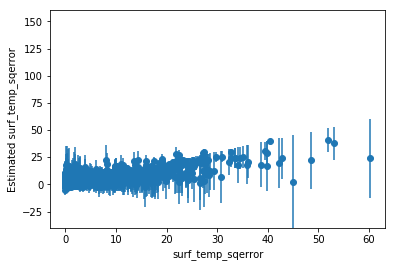

In [28]:
plt.errorbar(trueVals, predictedVals, yerr=diffVals, fmt='o')
axes = plt.axes()
axes.set_ylim([-40, 160])
plt.xlabel('surf_temp_sqerror')
plt.ylabel('Estimated surf_temp_sqerror')

In [19]:
import csv

def saver(dictex):
    for key, val in dictex.items():
        val = pd.DataFrame(val)
        val.to_csv("results/dnn/results_{}.csv".format(str(key)))

    with open("results/dnn/keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))
        
saver(results)

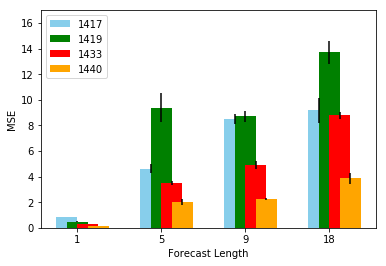

In [21]:
def loader():
    """Reading data from keys"""
    with open("results/dnn/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("results/dnn/results_{}.csv".format(str(key)))

    return dictex

results = loader()
graph_data = dict()
std_data = dict()
keys = [1417, 1419, 1433, 1440]

for key in keys:
    d = []
    st = []
    for i in [1, 5, 9, 18]:
        t = sum(results[(key, i)].values) / float(len(results[(key, i)]))
        s = np.std(results[(key, i)])[1]
        d.append(t[1])
        st.append(s)
    graph_data[key] = d
    std_data[key] = st

# Data for plotting
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ind = np.arange(len(graph_data[1417]))  # the x locations for the groups
width = 0.25  # the width of the bars

means, std = np.around(graph_data[1417], decimals=3), np.around(std_data[1417], decimals=3)
ax.bar(ind - width/2, means, width, yerr=std,
            color='SkyBlue', label=1417, align='center')

means, std = np.around(graph_data[1419], decimals=3), np.around(std_data[1419], decimals=3)
ax.bar(ind, means, width, yerr=std,
            color='Green', label=1419, align='center')

means, std = np.around(graph_data[1433], decimals=3), np.around(std_data[1433], decimals=3)
ax.bar(ind + width/2, means, width, yerr=std,
            color='Red', label=1433, align='center')

means, std = np.around(graph_data[1440], decimals=3), np.around(std_data[1440], decimals=3)
ax.bar(ind + width/2 + width/2, means, width, yerr=std,
            color='Orange', label=1440, align='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_xlabel('Forecast Length')
ax.set_xticks(ind)
ax.set_xticklabels((1, 5, 9, 18))
ax.set_ylim([0, 17])
ax.legend()


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')


#autolabel(rects1, "left")
#autolabel(rects2, "right")

plt.show()

In [40]:
print(neuron_params)

{(1419, 1): {'neurons': 74, 'epochs': 100, 'batch_size': 10}, (1419, 5): {'neurons': 235, 'epochs': 100, 'batch_size': 20}, (1419, 9): {'neurons': 267, 'epochs': 40, 'batch_size': 20}, (1419, 18): {'neurons': 138, 'epochs': 40, 'batch_size': 10}, (1433, 1): {'neurons': 138, 'epochs': 100, 'batch_size': 10}}


In [18]:
df = loader2()

In [15]:
from keras.models import load_model

def experiment3(repeats, data, key, params):
    X_train, X_test, y_train, y_test = getValues(data)
    X_train, X_test = normalize(X_train, X_test)

    MSE_benchmark = 100
    index_val = 20
    predictionsBest = list()
    trueBest = list()

    error_scores = list()
    results = pd.DataFrame()
    print(key)
    
    for r in range(repeats):
        forest_model = load_model('models/dnn/whole_models/model_{}_{}.h5'.format(key, r))
        
        predictions = forecast_nn(forest_model, X_test)
        true = y_test
                
        mse = mean_squared_error(true, predictions)
        print('%d) Test MSE: %.3f' % (r+1, mse))
        error_scores.append(mse)
        #plotPredictions(key, true, predictions)
        if (mse < MSE_benchmark):
            MSE_benchmark = mse
            predictionsBest = predictions
            trueBest = true
            index_val = r
    print(index_val, )
    return trueBest, predictionsBest, error_scores

In [16]:
%matplotlib inline

df = loader2()

repeats = 10
features = 1
results_old = dict()

trueVals_old = []
predictedVals_old = []

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        true, predictions, error_scores = experiment3(repeats, df[key], key, neuron_params[key])
        results_old[key] = error_scores
        trueVals_old.extend(true)
        predictedVals_old.extend(predictions)
        print(sizes)


(1419, 1)
1) Test MSE: 4.180
2) Test MSE: 4.007
3) Test MSE: 3.950
4) Test MSE: 3.950
5) Test MSE: 4.158
6) Test MSE: 3.925
7) Test MSE: 3.868
8) Test MSE: 3.788
9) Test MSE: 4.087
10) Test MSE: 4.006
7
[266760, 266760, 266760, 266787, 266787, 266787, 266787, 266787, 266787, 266787]
(1419, 5)
1) Test MSE: 179.815
2) Test MSE: 169.923
3) Test MSE: 181.698
4) Test MSE: 160.535
5) Test MSE: 185.423
6) Test MSE: 167.204
7) Test MSE: 179.843
8) Test MSE: 161.515
9) Test MSE: 178.765
10) Test MSE: 186.224
20
[266760, 266760, 266760, 266787, 266787, 266787, 266787, 266787, 266787, 266787]
(1419, 9)
1) Test MSE: 401.286
2) Test MSE: 443.477
3) Test MSE: 411.789
4) Test MSE: 400.652
5) Test MSE: 402.600
6) Test MSE: 426.709
7) Test MSE: 401.471
8) Test MSE: 419.481
9) Test MSE: 415.240
10) Test MSE: 425.262
20
[266760, 266760, 266760, 266787, 266787, 266787, 266787, 266787, 266787, 266787]
(1419, 18)
1) Test MSE: 445.172
2) Test MSE: 457.550
3) Test MSE: 444.159
4) Test MSE: 443.413
5) Test MSE

In [17]:
import csv

def saver(dictex):
    for key, val in dictex.items():
        val = pd.DataFrame(val)
        val.to_csv("results3/dnn/results_{}.csv".format(str(key)))

    with open("results3/dnn/keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))
        
saver(results_old)

In [21]:
result_old_means = dict()
result_means = dict()

for key in results_old:
    result_old_means[key] = np.mean(results_old[key])
    result_means[key] = np.mean(results[key])

In [22]:
result_old_means

{(1419, 1): 3.9920352908374546,
 (1419, 5): 175.09446016146538,
 (1419, 9): 414.79672271091624,
 (1419, 18): 441.4979447328884,
 (1433, 1): 2.451648234127459,
 (1433, 5): 66.97186894223013,
 (1433, 9): 116.53344294344322,
 (1433, 18): 130.5668083865454,
 (1440, 1): 1.183499013652838,
 (1440, 5): 19.593523653973904,
 (1440, 9): 60.44063873819046,
 (1440, 18): 89.68774413196049,
 (1417, 1): 10.11101745988294,
 (1417, 5): 5208.6979541832825,
 (1417, 9): 1536.4813478994522,
 (1417, 18): 12455.265743141841}

In [23]:
result_means

{(1419, 1): 2.9087200245130878,
 (1419, 5): 73.42668930639219,
 (1419, 9): 147.2472331466051,
 (1419, 18): 139.69379320844428,
 (1433, 1): 3.4268838203095067,
 (1433, 5): 23.580308693933386,
 (1433, 9): 30.7966730195134,
 (1433, 18): 54.536779077220025,
 (1440, 1): 1.1304119364242686,
 (1440, 5): 9.739271978757603,
 (1440, 9): 14.231346786238216,
 (1440, 18): 54.909082141679924,
 (1417, 1): 30.22855598818531,
 (1417, 5): 4656.890048368112,
 (1417, 9): 13545.74794788883,
 (1417, 18): 20472.445794144413}

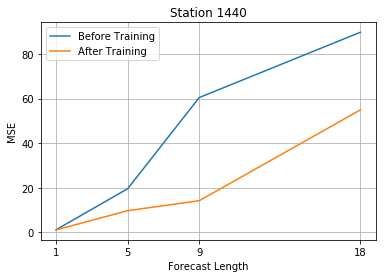

In [44]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

result_old_means = dict()
result_means = dict()

for key in results_old:
    result_old_means[key] = np.mean(results_old[key])
    result_means[key] = np.mean(results[key])

fig, ax = plt.subplots()

# Data for plotting
o = [result_old_means[(1440, 1)], result_old_means[(1440, 5)], result_old_means[(1440, 9)], result_old_means[(1440, 18)], ]
b = [1, 5, 9, 18]

ax.plot(b, o, label='Before Training')

# Data for plotting
t = [result_means[(1440, 1)], result_means[(1440, 5)], result_means[(1440, 9)], result_means[(1440, 18)], ]
s = [1, 5, 9, 18]

ax.plot(s, t, label='After Training')

ax.set(xlabel='Forecast Length', ylabel='MSE',
       title='Station 1440')
ax.grid()
ax.legend()
plt.xticks([1, 5, 9, 18])

fig.savefig("mse_improvement_dnn_1440.png")
plt.show()